In [7]:
# basic modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score 
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier

#settings
warnings.filterwarnings('ignore')
rs = 42
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)
c = StratifiedKFold(n_splits=3)

In [ ]:
df = pd.read_csv('./data/mimic_premodel.csv')

# Scaling and Train/Test-Split

In [ ]:
X = df.iloc[:, 1:]
y = df.label

In [ ]:
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs, stratify=y)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Functions

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Dummy Classifier

In [ ]:
dumm = DummyClassifier(strategy= "stratified", random_state=rs)
dumm.fit(X_train, y_train)
y_pred_dumm = dumm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_dumm)
np.set_printoptions(precision=2)

print(classification_report(y_test, y_pred_dumm))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_dumm, beta=0.5 ):.2f}')


In [ ]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [ ]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dumm)
plt.plot(fpr, tpr, linestyle='--',label="Dummy") 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_dumm_prob = dumm.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")

# Base Model

zuerst Standardeinstellungen für die Hyperparameter, danach Hyperparameter-Tuning (Random- und Grid-Search)

logistic regression (Jacqueline)  
decision tree (Nina)   
random forest (Nina)  
XGBoost (Niko)  
AdaBoost (Niko)  
SVM (Mirko)   
kNN (Mirko)   
Naive Bayes (Jacqueline) 

## Logistic Regression

### Hyperparameter by default

In [ ]:
lr = LogisticRegression(random_state=rs)
lr.fit(X_train, y_train)

In [ ]:
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr, beta=0.5 ):.2f}')

In [ ]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [ ]:
# Plot the ROC curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_prob = lr.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")

### Hyperparameter tuning

In [ ]:
# Hyperparameter grid for RandomSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [100, 10, 1, 0.1, 0.01] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = fhalf_scorer, cv = c, 
                        n_iter = 100, verbose = 1, random_state=rs)

# Fit 
lr_rs.fit(X_train, y_train)

In [ ]:
lr_rs.best_params_

In [ ]:
best_model_lr_rs = lr_rs.best_estimator_

In [ ]:
# Hyperparameter grid for GridSearch for Logistic Regression
param_grid = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'C': [5, 4, 3, 2, 1 , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08] 
}

# Estimator for use in random search
estimator = LogisticRegression(random_state = rs)

# Create the random search model
lr_gs = GridSearchCV(estimator, param_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
lr_gs.fit(X_train, y_train)

In [ ]:
lr_gs.best_params_

In [ ]:
best_model_lr_gs = lr_gs.best_estimator_

In [ ]:
y_pred_lr_best = best_model_lr_gs.predict(X_test)
print(classification_report(y_test, y_pred_lr_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_lr_best, beta=0.5 ):.2f}')

In [ ]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_lr_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [ ]:
# Plot the ROC curve
fpr_lr_best, tpr_lr_best, thresholds_lr_best = roc_curve(y_test, y_pred_lr_best)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_lr, tpr_lr, linestyle='-', label='Logistic Regression') 
plt.plot(fpr_lr_best, tpr_lr_best, linestyle=':', label='Best Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_lr_best_prob = best_model_lr_gs.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(logReg)= {roc_auc_score(y_test, y_pred_lr_prob[:,1]):.2f}")
print(f"AUC(BestlogReg)= {roc_auc_score(y_test, y_pred_lr_best_prob[:,1]):.2f}")

## Decision Tree 

In [ ]:
dtree_clf_base = DecisionTreeClassifier(random_state=rs)
dtree_clf_base.fit(X_train, y_train)

In [ ]:

y_pred_dtree_clf_base = dtree_clf_base.predict(X_test)

#### Evaluate Base Model

In [ ]:
print(classification_report(y_test, y_pred_dtree_clf_base))
print(confusion_matrix(y_test, y_pred_dtree_clf_base))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_dtree_clf_base, beta=0.5 ):.2f}')

In [ ]:
# ROC Curve Base Model and Dummy
fpr_dt_bm, tpr_dt_bm, thresholds_dt_bm = roc_curve(y_test, y_pred_dtree_clf_base)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_dt_bm, tpr_dt_bm, linestyle='-', label='DT Base Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_dtree_clf_base = dtree_clf_base.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_dtree_clf_base[:,1]):.2f}")

In [ ]:
# Look at parameters used by our current decision tree
print('Parameters currently in use:\n')
pprint(dtree_clf_base.get_params())

### Random Search

In [ ]:
# Set scorer for random search to f-beta 0.5
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [ ]:
# set cross-validation to a stratified split of 3
c_strat=StratifiedKFold(n_splits=3)

In [ ]:
# Maximum number of levels in tree
max_depth=[int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split=[2, 5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf=[1, 2, 4, 6, 8]

# Number of features to consider at every split
max_features=['auto', 'sqrt']

# Create the random grid
random_grid_dt = {
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
                }
pprint(random_grid)
#'max_depth': max_depth

In [ ]:
# Random search of parameters, using 3 fold cross validation 
dt_random = RandomizedSearchCV(estimator = dtree_clf_base, param_distributions = random_grid_dt, 
                               scoring=fhalf_scorer, n_iter = 100, cv = c_strat, verbose=2, 
                               random_state=rs, n_jobs = -1)

In [ ]:
dt_random.fit(X_train, y_train)

In [ ]:
dt_random.best_params_

In [ ]:
y_pred_dt_random = dt_random.predict(X_test)

### Grid Search

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
     'min_samples_split': [1, 2, 3, 4],
     'min_samples_leaf': [1, 2, 3, 4],
     'max_features': ['sqrt', 'auto'],
     'max_depth': [5, 10, 15, 20]
}

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dtree_clf_base, param_grid = param_grid, scoring=fhalf_scorer, 
                           cv = c_strat, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
y_pred_dt_grid = grid_search.predict(X_test)

#### Evaluate Grid Search

In [ ]:
print(classification_report(y_test, y_pred_dt_grid))
print(confusion_matrix(y_test, y_pred_dt_grid))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_dt_grid, beta=0.5 ):.2f}')

In [ ]:
# ROC Curve Random Search Model, Base Model and Dummy
fpr_dt_gs, tpr_dt_gs, thresholds_dt_gs = roc_curve(y_test, y_pred_dt_grid)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_dt_bm, tpr_dt_bm, linestyle='-', label='DT Base Model')
plt.plot(fpr_dt_gs, tpr_dt_gs, linestyle='-', label='RF Grid Search Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_dt_random = dt_random.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_dtree_clf_base[:,1]):.2f}")
print(f"AUC(GridSearch)= {roc_auc_score(y_test, y_proba_dt_random[:,1]):.2f}")

## Random Forest

### Base Model

In [ ]:
rf_clf_base = RandomForestClassifier(random_state=rs)
rf_clf_base.fit(X_train, y_train)

In [ ]:
y_pred_rf_clf_base = rf_clf_base.predict(X_test)

#### Evaluate Base Model

In [ ]:
print(classification_report(y_test, y_pred_rf_clf_base))
print(confusion_matrix(y_test, y_pred_rf_clf_base))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_clf_base, beta=0.5 ):.2f}')

In [ ]:
# ROC Curve Base Model and Dummy
fpr_rf_bm, tpr_rf_bm, thresholds_rf_bm = roc_curve(y_test, y_pred_rf_clf_base)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_clf_base = rf_clf_base.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")

In [ ]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_clf_base.get_params())

### Random Search

In [ ]:
# Set scorer for random search to f-beta 0.5
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [ ]:
# set cross-validation to a stratified split of 3
c_strat=StratifiedKFold(n_splits=3)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Random search of parameters, using 3 fold cross validation 
rf_random = RandomizedSearchCV(estimator = rf_clf_base, param_distributions = random_grid, scoring=fhalf_scorer, 
                               n_iter = 100, cv = c_strat, verbose=2, random_state=rs, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

### Grid Search

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3, 4],
    'n_estimators': [1000, 1500, 2000]
}

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_clf_base, param_grid = param_grid, scoring=fhalf_scorer, 
                           cv = c_strat, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
y_pred_rf_clf_grid = grid_search.predict(X_test)

#### Evaluate Grid Search

In [ ]:
print(classification_report(y_test, y_pred_rf_clf_grid))
print(confusion_matrix(y_test, y_pred_rf_clf_grid))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_rf_clf_grid, beta=0.5 ):.2f}')

In [ ]:
# ROC Curve Random Search Model, Base Model and Dummy
fpr_rf_gs, tpr_rf_gs, thresholds_rf_gs = roc_curve(y_test, y_pred_rf_clf_grid)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_rf_bm, tpr_rf_bm, linestyle='-', label='RF Base Model')
plt.plot(fpr_rf_gs, tpr_rf_gs, linestyle='-', label='RF Grid Search Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_proba_rf_clf_random = rf_random.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(BaseModel)= {roc_auc_score(y_test, y_proba_rf_clf_base[:,1]):.2f}")
print(f"AUC(GridSearch)= {roc_auc_score(y_test, y_proba_rf_clf_random[:,1]):.2f}")

## XGBoost

In [ ]:
# instanciate classifier, fit model
xgboost = XGBClassifier(random_state=rs)
xgboost.fit(X_train, y_train)

In [ ]:
y_pred_xgb = xgboost.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_xgb))

In [ ]:
fbeta_score(y_test, y_pred_xgb, beta=0.5)

In [ ]:
cm = confusion_matrix(y_test, xgboost.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

In [ ]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = xgboost.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

### random search

In [ ]:
xgb_grid = dict()
xgb_grid['max_depth'] = [2, 3, 4, 5, 6]
xgb_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
xgb_grid['gamma'] = [0,0.1,0.2,0.3,0.4,0.5]

model = XGBClassifier()
grid = xgb_grid
    
# run randomized search and optimize for fhalf_scorer
clf = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs,cv=c)
search = clf.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
print(search.best_params_)

best result: {'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5}

In [ ]:
y_pred_xgb_rdm = clf.predict(X_test)

In [ ]:
fbeta_score(y_test, y_pred_xgb_rdm, beta=0.5)

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

In [ ]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_lr = roc_curve(y_test, y_pred_xgb_rdm)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = clf.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

### Gridsearch

In [ ]:
param_grid = {
    'max_depth': [2,3,4],
    'learning_rate': [0.2, 0.15, 0,25],
    'gamma': [0.5, 0.55, 0.45],}

optimal_params = GridSearchCV(
    estimator= XGBClassifier(), cv=c,
    param_grid=param_grid,
     scoring = fhalf_scorer)## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 4}

In [ ]:
y_pred_xgb_grid = optimal_params.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_xgb_grid))

In [ ]:
fbeta_score(y_test, y_pred_xgb_grid, beta=0.5)

In [ ]:
cm = confusion_matrix(y_test, optimal_params.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

In [ ]:
# Plot the ROC curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_grid)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_xgb, tpr_xgb, linestyle='-', label='Xgboost_Grid')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_prob = optimal_params.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_prob[:,1]):.2f}")

### best Xgboost model {'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5}

In [ ]:
# instanciate classifier, fit model
xgboost_best = XGBClassifier(max_depth= 3, learning_rate= 0.2, gamma= 0.5, random_state=rs)
xgboost_best.fit(X_train, y_train)

In [ ]:
y_pred_xgb_best = xgboost_best.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_xgb_best))

In [ ]:
fbeta_score(y_test, y_pred_xgb_best, beta=0.5)

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb_best)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

In [ ]:
# Plot the ROC curve
fpr_xgb_best, tpr_xgb_best, thresholds_xgb_best = roc_curve(y_test, y_pred_xgb_best)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_xgb_best, tpr_xgb_best, linestyle='-', label='Xgboost_best')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_xgb_best_prob = xgboost_best.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Xgboost)= {roc_auc_score(y_test, y_pred_xgb_best_prob[:,1]):.2f}")

## AdaBoost

In [ ]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

In [ ]:
fbeta_score(y_test, y_pred_ada, beta=0.5)

In [ ]:
cm = confusion_matrix(y_test, ada.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

In [ ]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

### Randomsearch

In [ ]:
xgb_grid = dict()
xgb_grid['max_depth'] = [2, 3, 4, 5, 6]
xgb_grid['learning_rate'] = [0.01, 0.05, 0.1, 0.2, 0.4]
xgb_grid['gamma'] = [0,0.1,0.2,0.3,0.4,0.5]

model = AdaBoostClassifier()
grid = xgb_grid
    
# run randomized search and optimize for fhalf_scorer
clf = RandomizedSearchCV(estimator=model,param_distributions=grid,n_iter = 10,verbose=1,
                         scoring=fhalf_scorer, random_state=rs, cv=c)
search = ada_rdm.fit(X_train, y_train)
predictions = search.best_estimator_.predict(X_test)

In [ ]:
print(search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 500}

In [ ]:
y_pred_ada_rdm = ada_rdm.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_ada_rdm))

In [ ]:
fbeta_score(y_test, y_pred_ada_rdm, beta=0.5)

In [ ]:
cm = confusion_matrix(y_test, ada_rdm.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

In [ ]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_rdm.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

### Gridsearch

In [ ]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

# TODO: Initialize the classifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[500],                
              'learning_rate':[0.1, 0.5, 0.15,],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# TODO: Make an fbeta_score scoring object
scorer = fhalf_scorer

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(ada, parameters,scorer, cv=c) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_ada = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (ada.fit(X_train, y_train)).predict(X_test)
best_predictions = best_ada.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_ada)


In [ ]:
ada_grid = AdaBoostClassifier(base_estimator=DecisionTreeClassifier
                              (max_depth=2,
                               min_samples_split=6),
                              learning_rate=0.1, 
                              n_estimators=500)
ada_grid.fit(X_train, y_train)

In [ ]:
y_pred_ada_grid = ada_grid.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_ada_grid))

In [ ]:
fbeta_score(y_test, y_pred_ada_grid, beta=0.5)

In [ ]:
cm = confusion_matrix(y_test, ada_grid.predict(X_test),)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data
# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')


plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.title('Confusion matrix', fontsize=15, fontweight="bold")

In [ ]:
# Plot the ROC curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_ada, tpr_ada, linestyle='-', label='Adaboost')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_ada_prob = ada_grid.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(Adaboost)= {roc_auc_score(y_test, y_pred_ada_prob[:,1]):.2f}")

## SVM

### Simple Classifier

In [ ]:
svc_model = SVC(C=1, kernel='rbf', probability=True, random_state=rs)
svc = svc_model.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc, beta=0.5 ):.2f}')

In [ ]:
y_pred_svc_prob = svc.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_svc_prob[:,1]):.2f}')

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc)
auc_score = roc_auc_score(y_test, y_pred_svc)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Base SVC', loc='left')
plt.title(f'AUC Score: {auc_score:.3f}', loc='right');

### Optimize Model

In [ ]:
grid_svc = {'C': [0.1,1, 10, 50, 100],
             'kernel': ['linear', 'rbf', 'poly','sigmoid'],
             'gamma' : [1, 0.1, 0.01, 0.001]
             }

In [ ]:
svc_grid = GridSearchCV(SVC(), 
                        param_grid=grid_svc, 
                        cv=c, 
                        verbose=False, n_jobs=-1,
                        probability=True, random_state=rs,
                        scoring=fhalf_scorer)

In [ ]:
svc_grid.fit(X_train, y_train)
y_pred_svc_grid = svc_grid.predict(X_test)
svc_grid.best_params_

In [ ]:
print(classification_report(y_test, y_pred_svc_grid))
print(confusion_matrix(y_test, y_y_pred_svc_gridpred))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_svc_grid, beta=0.5 ):.2f}')

In [ ]:
results = pd.DataFrame(svc_grid.cv_results_)
results.sort_values('rank_test_score').head()

## kNN

### Simple kNN

In [ ]:
train_accuracy = []
test_accuracy = []
train_beta = []
test_beta = []

# Probiere Werte für k von 1 bis 10 aus
neighbor_settings = range(1, 20)

for k in neighbor_settings:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_beta.append(fbeta_score(y_test, y_pred, beta=0.5))
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbor_settings, train_accuracy, label='Accuracy Training')
plt.plot(neighbor_settings, test_accuracy, label='Accuracy Test')
plt.ylabel('Accuracy')
plt.xlabel('Number neighbors')
plt.legend();

In [ ]:
plt.plot(neighbor_settings, train_beta)
plt.ylabel('F-beta-score')
plt.xlabel('Number neighbors')
plt.xticks(ticks=list(range(0,21,2)) ,labels=list(range(1,21,2)));

We take 17 neighbours as best value, for the first simple model.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
y_pred_knn= knn.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_knn, beta=0.5 ):.2f}')

In [ ]:
y_pred_knn_prob = clf.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_knn_prob[:,1]):.2f}')

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)
auc_score = roc_auc_score(y_test, y_pred_knn)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, linewidth=2) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Base KNN', loc='left')
plt.title(f'AUC Score: {auc_score}', loc='right');

### Optimize Model

In [ ]:
grid_knn = {'n_neighbors' : list(range(1,30)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,20)),
             'metric' : ['euclidean','minkowski','manhattan']
             }

In [ ]:
knn_grid_mod = GridSearchCV(KNeighborsClassifier(), 
                        param_grid=grid_knn, 
                        cv=c, 
                        verbose=False, n_jobs=-1,
                        scoring=fhalf_scorer)
knn_grid_mod.fit(X_train, y_train)
y_pred = knn_grid_mod.predict(X_test)


In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred, beta=0.5 ):.2f}')

In [ ]:
knn_grid_mod.best_params_

In [ ]:
y_pred_prob = knn_grid_mod.predict_proba(X_test)
print(f'ROC-AUC-Score = {roc_auc_score(y_test, y_pred_prob[:,1]):.2f}')

## Naive Bayes

### Hyperparameter by default

In [ ]:
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_gnb))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb, beta=0.5 ):.2f}')

In [ ]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [ ]:
# Plot the ROC curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_gnb)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Gaussian Naive Bayes') 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_prob = gnb.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")

### Hyperparameter Tuning

In [ ]:
# Hyperparameter grid for GridSearch for Naive Bayes
params_grid = {'var_smoothing': np.logspace(1,-9, num=1000)}

# Estimator for use in gridSearch
estimator = GaussianNB()

# Create the gridSearch model
gnb_gs = GridSearchCV(estimator, params_grid, scoring= fhalf_scorer, cv = c,
                     n_jobs = -1, verbose = 1)

# Fit 
gnb_gs.fit(X_train, y_train)

In [ ]:
gnb_gs.best_params_

In [ ]:
best_model_gnb_gs = gnb_gs.best_estimator_

In [ ]:
y_pred_gnb_best = best_model_gnb_gs.predict(X_test)
print(classification_report(y_test, y_pred_gnb_best))
print(f'F-Beta-Score(0.5) =  {fbeta_score(y_test, y_pred_gnb_best, beta=0.5 ):.2f}')

In [ ]:
# Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_gnb_best)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Failed','Succeeded'],
                      normalize= False,  title='Confusion matrix')

In [ ]:
# Plot the ROC curve
fpr_gnb_best, tpr_gnb_best, thresholds_gnb_best = roc_curve(y_test, y_pred_gnb_best)
plt.plot(fpr, tpr, linestyle='--', label='Dummy')
plt.plot(fpr_gnb, tpr_gnb, linestyle='-', label='Naive Bayes') 
plt.plot(fpr_gnb_best, tpr_gnb_best, linestyle=':', label='Best Naive Bayes')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
y_pred_gnb_best_prob = best_model_gnb_gs.predict_proba(X_test)
print(f"AUC(Dummy) = {roc_auc_score(y_test, y_pred_dumm_prob[:,1]):.2f}")
print(f"AUC(GNB)= {roc_auc_score(y_test, y_pred_gnb_prob[:,1]):.2f}")
print(f"AUC(BestGNB)= {roc_auc_score(y_test, y_pred_gnb_best_prob[:,1]):.2f}")

# Overview

In [10]:
models = {"Dummy": [0.66, 0.66, 0.51, 0.56],
          "LogRegres": [0.69, 0.73, 0.69, 0.68],
          "DecisionTree": [0.68, 0.70, 0.60, 0.62],
          "RandomForrest": [0.71, 0.74, 0.68, 0.69 ],
          "AdaBoost": [0.72, 0.743, 0.68, 0.69],
          "XGBBoost": [0.72, 0.745, 0.69, 0.69],
          "SVM": [0.70,0.73,0.66,0.68],
          "KNN": [0.69 ,0.73, 0.62,0.68],
          "GNB": [0.69,0.72,0.65, 0.65]}

In [11]:
overview = pd.DataFrame.from_dict(models, orient='index')
overview.columns = ["Precision", "F-Beta(0.5)", "Roc-Auc-Score", "Accuracy"]
overview

,Precision,F-Beta(0.5),Roc-Auc-Score,Accuracy
Dummy,0.66,0.660,0.51,0.56
LogRegres,0.69,0.730,0.69,0.68
DecisionTree,0.68,0.700,0.60,0.62
RandomForrest,0.71,0.740,0.68,0.69
AdaBoost,0.72,0.743,0.68,0.69
XGBBoost,0.72,0.745,0.69,0.69
SVM,0.70,0.730,0.66,0.68
KNN,0.69,0.730,0.62,0.68
GNB,0.69,0.720,0.65,0.65


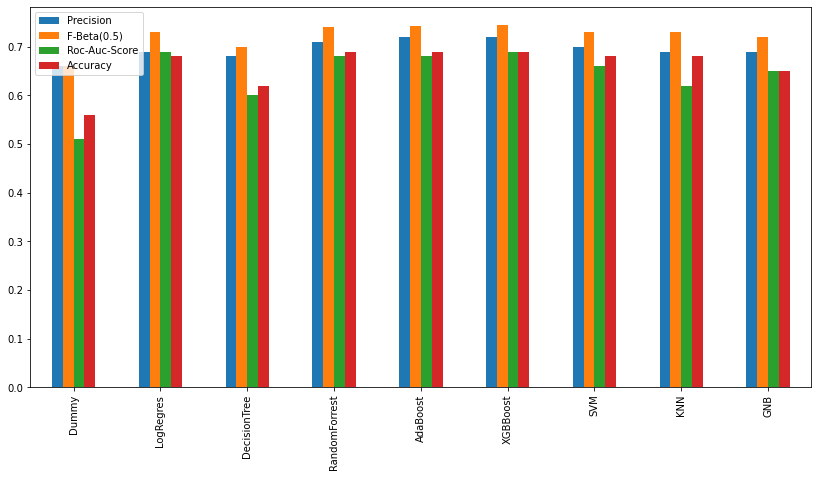

In [12]:
overview.plot(kind='bar', figsize=(14,7));

# Feature Importance

## Logistic Regression

In [ ]:
# get importance
importance_logreg = best_model_lr_gs.coef_[0]
# summarize feature importance
for i,v in enumerate(importance_logreg):
	print('Feature: %0d, Score: %.5f' % (i,v), X.columns[i] )
# plot feature importance
plt.bar([x for x in range(len(importance_logreg))], importance_logreg)
plt.show()